**循环神经网络**

@ Date: 2025-08-07<br>
@ Author: Rui Zhu<br>
@ Images From: https://d2l.ai/chapter_recurrent-neural-networks/index.html<br>
@ 概览<br>
1. 循环神经网络(recurrent neural networks, RNNs)是一类用于处理序列数据的神经网络.
2. 自回归模型(auto-regressive models, AR): 一种利用历史数据预测未来数据的建模方法，其核心思想是当前时间步的输出仅依赖于过去时间步的观测值.
3. 隐变量自回归模型(latent auto-regressive models): 保留一些对过去观测的总结$h_t$，同时更新预测$\hat{x}_t$, 使用$h_t$和$\hat{x}_t$来更新模型.
4. 马尔可夫模型: 一种基于概率的随机过程模型，其核心假设是“未来状态只依赖于当前状态，而与过去状态无关”，这一性质称为马尔可夫性.

In [2]:
from pathlib import Path

---
# 初探序列数据

In [3]:
import torch
from torch import nn
from d2l import torch as d2l

## 数据准备

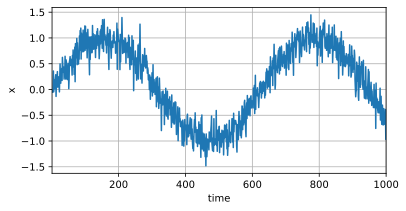

In [4]:
T = 1000  # 总共生成1000个数据点

time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [5]:
# 将数据转换成模型的特征-标签对
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T-tau+i]
labels = x[tau:].reshape((-1, 1))

## 定义网络

In [6]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

def get_net():
    net = nn.Sequential(nn.Linear(4, 10), 
                        nn.ReLU(), 
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

loss = nn.MSELoss(reduction='none')  # 计算平方误差时不带系数

## 训练

In [7]:
batch_size, n_train = 16, 600
train_iter = d2l.load_array(
    (features[: n_train], labels[: n_train]), 
    batch_size, is_train=True
)

In [8]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}'
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')
    
net = get_net()
train(net, train_iter, loss, 5, 0.1)

epoch 1loss: 0.053899
epoch 2loss: 0.061139
epoch 3loss: 0.063342
epoch 4loss: 0.092943
epoch 5loss: 0.055826


## 预测
- 单步预测效果好, 多步预测效果差
- 单步预测: 给定时间序列, 预测下一个时间步
- 多步预测: 递归进行单步预测, 上一步的预测输出作为下一步的输入, 误差会逐步累积

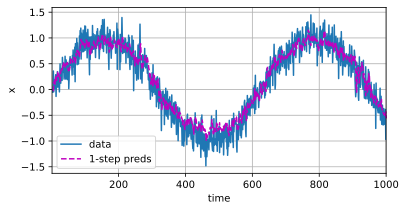

In [9]:
# 单步预测
onestep_preds = net(features)
d2l.plot([time, time[tau:]], 
         [x.detach().numpy(), onestep_preds.detach().numpy()], 
         'time', 'x', legend=['data', '1-step preds'],
         xlim=[1, 1000], figsize=(6, 3))

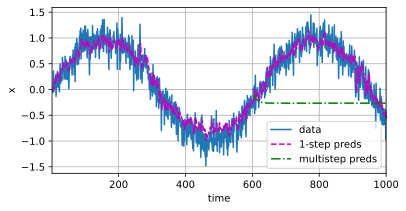

In [10]:
# 多步预测
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau: i].reshape((1, -1))
    )
d2l.plot([time, time[tau:], time[n_train + tau:]], 
         [x.detach().numpy(), onestep_preds.detach().numpy(), 
          multistep_preds[n_train + tau: ].detach().numpy()], 
         'time', 'x', legend=['data', '1-step preds', 'multistep preds'], 
         xlim=[1, 1000], figsize=(6, 3))


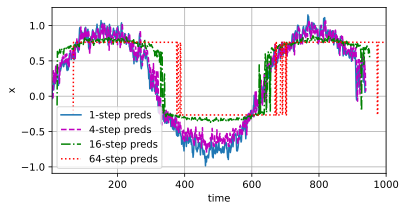

In [11]:
max_steps= 64
features = torch.zeros((T-tau-max_steps+1, tau+max_steps))

for i in range(tau):
    features[:, i] = x[i: i+T-tau-max_steps+1]

for i in range(tau, tau+max_steps):
    features[:, i] = net(features[:, i-tau: i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i -1: T - max_steps + i] for i in steps], 
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 
         'time', 'x', legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000], 
         figsize=(6, 3))

---
# 文本预处理

In [12]:
import collections
import re
from d2l import torch as d2l

## 数据集
- The Time machine by H.G. Wells

In [13]:
def read_time_machine():
    path = Path("/Users/rui/Code/Astronote/32_PyTorch/data/chapter8/timemachine.txt")
    if path.exists():
        with open(path, 'r') as f:
            lines = f.readlines()
    else:
        raise FileNotFoundError(f"File not found: {path}")
    
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()  # 文本行列表，每个元素是一个文本行
print(f'# {len(lines)} lines')
print(lines[0])
print(lines[10])

# 3221 lines
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


## 词元化
- 将文本行拆分成一个词元列表
- 词元(token)是文本的基本单位

In [14]:
def tokenize(lines, token='word'):
    """将文本行拆分成单词或字符词元"""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('Error: unknown token type: ' + token)

tokens = tokenize(lines)
for i in range(11):
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


## 词表与语料库
- 词表(vocabulary): 一个字典, 用来将字符串类型的词元映射到从0开始的数字索引中, 索引大小按语料库中出现的频率进行调整
- 语料库(corpus): 合并所有文档中的词元, 对唯一词元进行统计, 得到的统计结果称为语料库

In [15]:
def count_corpus(tokens):
    """统计词元出现的频率"""
    if len(tokens) == 0 or isinstance(tokens[0], list):
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

class Vocab:
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        
        # 按照出现频率排序
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)

        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1
        
    def __len__(self):
        return len(self.idx_to_token)
    
    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]
    
    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property  # 方法变成属性使用
    def unk(self):
        return 0
    
    @property
    def token_freqs(self):
        return self._token_freqs

In [16]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])  # 打印前几个高频词及其索引

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


In [17]:
# 将每个文本行转换成数字索引列表
for i in [0, 10]:
    print(f"token: {tokens[i]}")
    print(f"idx: {vocab[tokens[i]]}")

token: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
idx: [1, 19, 50, 40, 2183, 2184, 400]
token: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
idx: [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


In [18]:
# 功能打包函数
def load_corpus_time_machine(max_tokens=-1):
    """返回时光机器数据集的词元索引列表和词表"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

(170580, 28)

---
# 语言模型和数据集
- 语言模型(Language Model): 假设长度为T(即有T个词元)的文本序列中的词元($x_1, x_2, \ldots, x_T$). $x_t$可以认为是文本序列在时序步t处的预测或标签. 语言模型的目标基于此样本序列, 估计序列的联合概率$P(x_1, x_2, \ldots, x_T)$.
- 拉普拉斯平滑(Laplace smoothing, 又称加一平滑Add-One Smoothing): 一种用于概率估计的技术，主要用于解决零概率问题（即某些事件在训练数据中未出现，导致其概率被估计为0的问题）。它通过给所有可能的计数加一个小的常数（通常为1），确保即使未观察到的事件也会被赋予一个非零概率。
- 马尔可夫模型: 马尔可夫模型是一种随机过程模型，用于描述一系列可能的事件（或状态），其中未来的状态仅依赖于当前状态，而与过去的状态无关。这一特性称为马尔可夫性质（Markov Property）。
    数学表达: $$P(x_{t+1} | x_t, x_{t-1}, \ldots, x_1) = P(x_{t+1} | x_t)$$
- n元语法(n-gram): n元语法是一种基于马尔可夫模型的语言模型，它通过考虑连续的n个词元来捕捉上下文信息。具体地，n元语法模型估计一个词元在给定其前面n-1个词元的条件下出现的概率。

## 词频统计
- 停用词(stop word): 在自然语言处理任务中，被预先过滤掉的常见高频词。这些词通常对文本的语义贡献较小，但出现频率极高，移除它们可以减少数据噪声、提升模型效率。
- 词频衰减的速度相当快; 且在双对数坐标图上是一条直线, 即满足Zipf's law
- 本节对比了3种不同的n-gram模型中的词频, 结论:
    1. 词频均遵循Zipf's law
    2. n增大, 词频急剧下降, 说明语言中存在相当多的结构
    3. 很多n元组出现的频率很低, 使得拉普拉斯平滑非常不适合语言建模

In [24]:
import random
import torch
from d2l import torch as d2l

# 构建词表
tokens = d2l.tokenize(read_time_machine())
corpus = [token for line in tokens for token in line]
vocab = Vocab(tokens)
vocab.token_freqs[:10]  # 打印前10个高频词及其频率

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

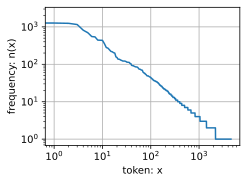

In [26]:
# 一元语法提取的词频遵循Zipf's law

freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel='token: x', ylabel='frequency: n(x)', xscale='log', yscale='log')

In [30]:
# 二元语法
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_tokens = Vocab(bigram_tokens)
bigram_tokens.token_freqs[:10]  # 打印前10个高频二元语法及其频率

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

In [31]:
# 三元语法
trigram_tokens = [triple for triple in zip(
    corpus[:-2], corpus[1:-1], corpus[2:]
)]
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]  # 打印前10个高频三元语法及其频率

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

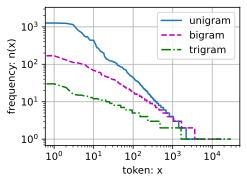

In [32]:
# 对比3种模型中的词频
bigram_freqs = [freq for token, freq in bigram_tokens.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]

d2l.plot(
    [freqs, bigram_freqs, trigram_freqs],
    xlabel='token: x',
    ylabel='frequency: n(x)',
    xscale='log',
    yscale='log',
    legend=['unigram', 'bigram', 'trigram']
)

## 读取长序列数据